In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas
import numpy

In [2]:
def vocabulary_size(data, column="Cognate_Set"):
    """Count different words in vocabulary."""
    return len(set(data[column]))

In [3]:
def semantic_width(data, column="Cognate_Set"):
    """Calculate average synonym count.

    Calculate the average weighted semantic width in the language
    represented by data.

    """
    width = 0
    m = 0
    for form, meanings in data.groupby(column):
        width += meanings["Weight"].sum()**2/(meanings["Weight"]**2).sum()
        m += 1
    return width/m

In [4]:
def synonymity(data):
    """Calculate average synonym count.

    Calculate the average weighted synonym count in the language
    represented by data.

    """
    return semantic_width(data, column="Feature_ID")

In [6]:
try:
    clics_words = pandas.read_csv("words.csv")
except FileNotFoundError:
    import urllib.request
    data = urllib.request.urlopen(
        "https://github.com/clics/clics-data/blob/master/data/words.csv?raw=true")
    clics_words = pandas.read_csv(data)

clics_words["Weight"] = 1

clics_vocabulary = []
clics_semantic_width = []
clics_synonymity = []
for language, words in clics_words.groupby("LanguageId"):
    clics_vocabulary.append(vocabulary_size(words, "ClicsValue"))
    clics_semantic_width.append(semantic_width(words, "ClicsValue"))
    clics_synonymity.append(semantic_width(words, "ConcepticonGloss"))

In [7]:
path = "../"

def condition(file):
    if not (file.startswith("trivial_long_") and file.endswith(".csv")):
        return False
    x = True
    properties = {s[0]: s[1:] for s in file[13:-4].split("_")}
    print(file, properties)
    x &= properties.get("i", "100") in ["poisson100", "d199", "100"] 
    x &= float(properties.get("n", 0.004)) == 0.004
    x &= float(properties.get("w", 2)) == 2
    x &= properties.get("c", "degree_squared") == "degree_squared"
    return x

trivial_long_branche95a_r-6_id199_w2.000000_n0.004.csv {'b': 'ranche95a', 'r': '-6', 'i': 'd199', 'w': '2.000000', 'n': '0.004'}
trivial_long_branche95a_r-6_id199_w2.000000_n0.004.csv
trivial_long_branche95b_r-6_i100_w2_n0.004.csv {'b': 'ranche95b', 'r': '-6', 'i': '100', 'w': '2', 'n': '0.004'}
trivial_long_branche95b_r-6_i100_w2_n0.004.csv
Clics: 1.0±0.0


KeyError: 8388608

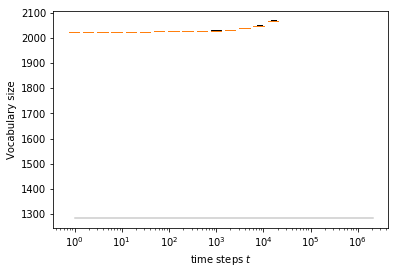

In [8]:
import os
n = {}
for file in os.listdir(path):
    if condition(file):
        print(file)
        all_data = pandas.read_csv(
            os.path.join(path, file),
            sep=",",
            na_values=[""],
            keep_default_na=False,
            encoding='utf-8')

        for language_id, language_data in all_data.groupby("Language_ID"):
            n.setdefault(int(language_id), []).append(vocabulary_size(language_data))

plt.boxplot(list(n.values()), positions=list(n.keys()), widths=[i/2 for i in n.keys()], manage_xticks=False)

plt.plot([1, 2*1048576], [1284, 1284], '0.8', label="Root #Words")

plt.xlabel("time steps $t$")
plt.gca().set_xscale('log')
plt.ylabel("Vocabulary size")
print("Clics: {:0.1f}±{:0.1f}".format(
    numpy.mean(clics_vocabulary), numpy.std(clics_vocabulary)))
stable = numpy.array(sum([n[2**i] for i in range(23, 27)], []))
print("Simulation: {:0.1f}±{:0.1f}".format(stable.mean(), stable.std()))
plt.gcf().set_size_inches(5,4)
plt.savefig("vocabularysize_timesteps.pdf")


In [ ]:
n[16777216]

In [ ]:
import os
n = {}
c = {}
p = {}
for file in os.listdir(path):
    if condition(file):
        all_data = pandas.read_csv(
            os.path.join(path, file),
            sep="\t",
            na_values=[""],
            keep_default_na=False,
            encoding='utf-8')

        print(file)
        for language_id, language_data in all_data.groupby("Language_ID"):
            n.setdefault(int(language_id), []).append(synonymity(language_data))
            
            sum_width = 0
            m = 0
            accs, widths = [], []
            for form, meanings in language_data.groupby("Cognate_Set"):
                width = meanings["Weight"].sum()**2/(meanings["Weight"]**2).sum()
                accs.append(meanings["Weight"].sum())
                widths.append(width)
                sum_width += width
                m += 1
            c.setdefault(int(language_id), []).append(numpy.corrcoef(accs, widths)[1, 0])
            p.setdefault(int(language_id), []).append(sum_width/m)

plt.boxplot(list(n.values()), positions=list(n.keys()), widths=[i/2 for i in n.keys()], manage_xticks=False)
plt.boxplot(list(p.values()), positions=list(p.keys()), widths=[i/2 for i in p.keys()], manage_xticks=False,
               boxprops=dict(color='blue'), medianprops=dict(color='red'))

plt.plot([1, 2*1048576], [1, 1], '0.8')

plt.plot([0,0],[1,1],c='red',label="Polysemy")
plt.plot([0,0],[1,1],c='orange',label="Synonymity")
plt.xlabel("time steps $t$")
plt.gca().set_xscale('log')
plt.ylabel("Average Polysemy/Synonymity")
plt.legend()
print("Synonymity")
#print("Clics: {:0.1f}±{:0.1f}".format(
#    numpy.mean(clics_synonymity), numpy.std(clics_synonymity)))
stable = numpy.array([n[2**i] for i in range(20, 22)])
# print("Simulation: {:0.1f}±{:0.1f}".format(stable.mean(), stable.std()))
print("Polysemy")
# print("Clics: {:0.1f}±{:0.1f}".format(
#    numpy.mean(clics_semantic_width), numpy.std(clics_semantic_width)))
stable = numpy.array([p[2**i] for i in range(20, 22)])
#print("Simulation: {:0.1f}±{:0.1f}".format(stable.mean(), stable.std()))
plt.gcf().set_size_inches(5,4)
plt.savefig("synonymitypolysemy_timesteps.pdf")


In [ ]:
plt.boxplot(list(c.values()), positions=list(c.keys()), widths=[i/2 for i in c.keys()], manage_xticks=False)

plt.xlabel("time steps $t$")
plt.gca().set_xscale('log')
plt.ylabel("Correlation between semantic width and accessibility")
plt.legend()

plt.gcf().set_size_inches(5,4)
plt.savefig("correlation_timesteps.pdf")
